## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

full_text = ''.join([x.lower() for x in text])

assert len(full_text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(full_text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(full_text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
token_to_idx = {token: i for i, token in enumerate(tokens)}
idx_to_token = {j: i for i, j in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class VanillaRNN(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        h_sequence, _ = self.rnn_update(self.embedding(x))
        upd_logits = self.rnn_to_logits(h_sequence)
        return upd_logits
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

In [7]:
def to_matrix(data, token_to_id, max_len=256):
    result = []
    for d in data:
        this = []
        for c in d:
            this.append(token_to_id[c.lower()])
        new_len = max_len - len(this)
        for _ in range(new_len):
            this.append(token_to_id[' '])
        result.append(this)
    return result

In [8]:
vanilla_rnn = VanillaRNN()
opt = torch.optim.Adam(vanilla_rnn.parameters())
storage = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

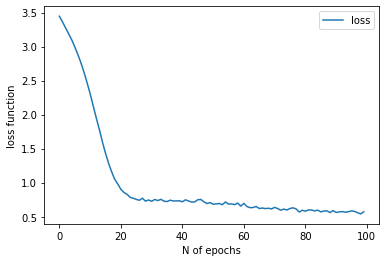

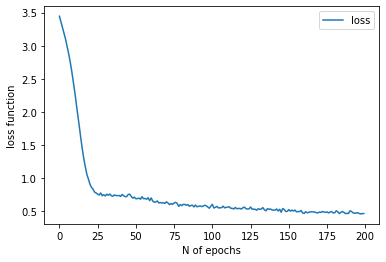

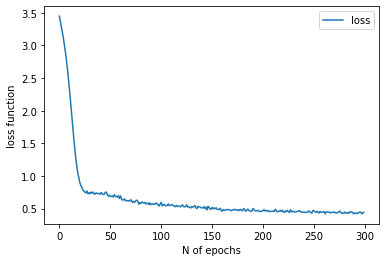

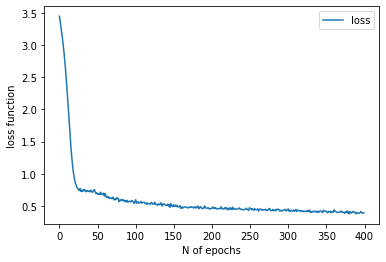

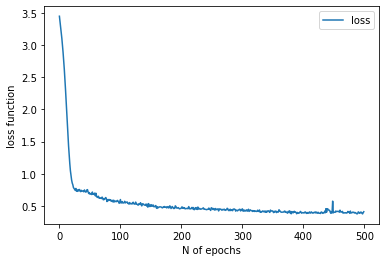

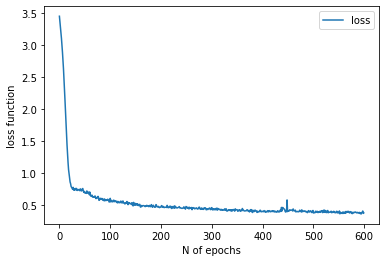

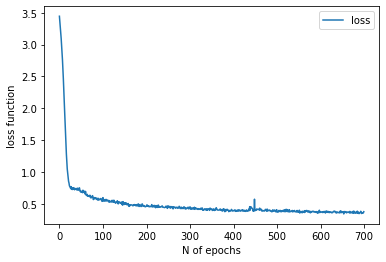

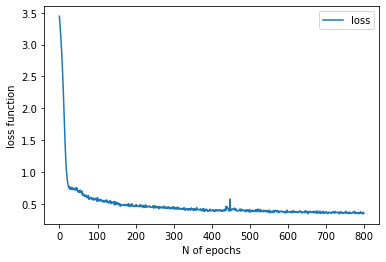

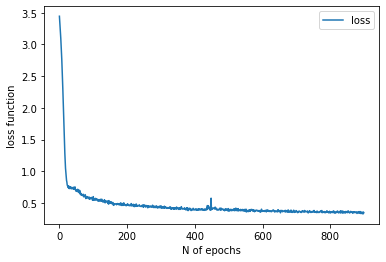

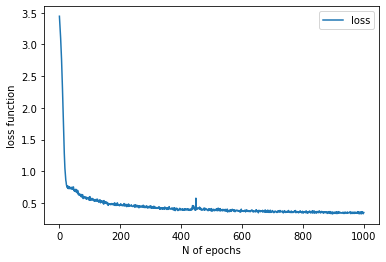

In [10]:
import numpy as np
import matplotlib.pyplot as plt

batch_size = 64
max_iter = 1000

for i in range(1, max_iter + 1):
    indexes = np.random.randint(0, len(text) - batch_size, size=batch_size)
    substrings = [text[idx : idx + batch_size] for idx in indexes]
    
    batch_ix = to_matrix(substrings[0], token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)    
    
    logp_sequence = vanilla_rnn(batch_ix)
    
    predictions_logp = F.log_softmax(logp_sequence[:, :-1], dim=-1)
    real_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=real_next_tokens[:, :, None]))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    storage.append(loss.data.numpy())
    
    if i % (max_iter // 10) == 0:
        plt.plot(storage, label='loss')
        plt.xlabel("N of epochs")
        plt.ylabel("loss function")
        plt.legend()
        plt.show()

In [12]:
def generate_sample(vanilla_rnn, seed_phrase=' Hello', max_length=256, temperature=1.0):
    
    x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    out = vanilla_rnn(x_sequence[:, 0])
    
    for _ in range(max_length - len(seed_phrase)):
        
        out = vanilla_rnn(x_sequence[:, -1, :])
        pred_next = F.softmax(out[:, -1, :] / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=pred_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix.view((1,1,1))], dim=-1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy().squeeze()])

In [15]:
print(generate_sample(vanilla_rnn, seed_phrase = ' a', temperature = 0.7, max_length=100))

 amrt man fhees than thiy so t mor inds the  noh  tos fand,
                                        


Что-то получилось :D Учитывая, что мы опирались на токены, выглядит даже не плохо

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [20]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm_update = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.lstm_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        h_sequence, _ = self.lstm_update(self.embedding(x))
        upd_logits = self.lstm_to_logits(h_sequence)
        return upd_logits
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

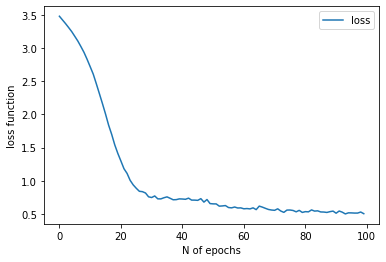

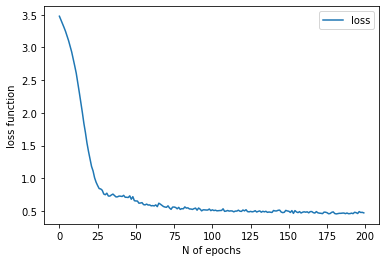

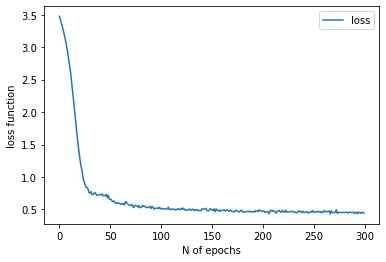

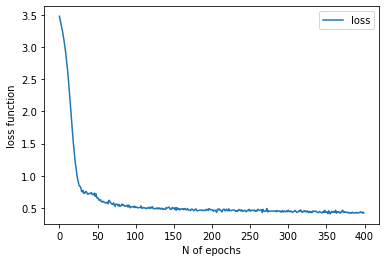

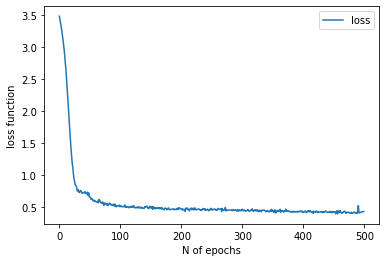

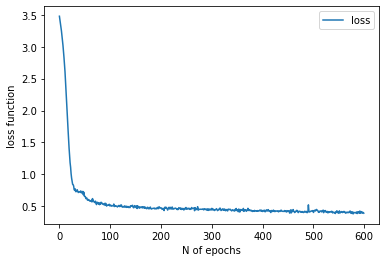

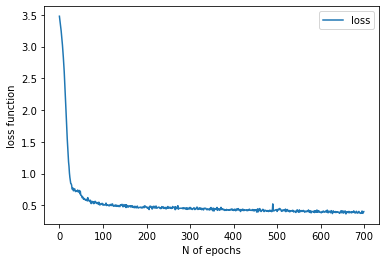

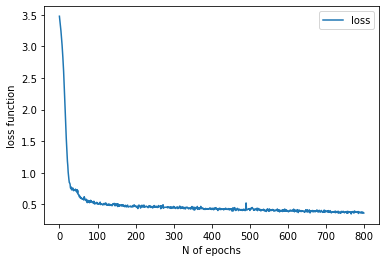

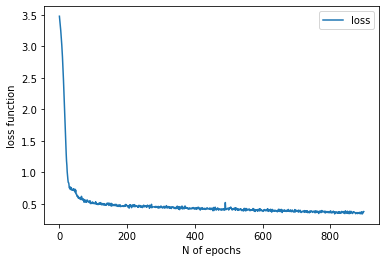

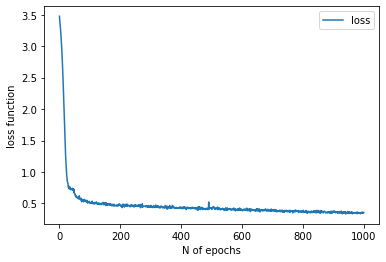

In [21]:
char_lstm = CharLSTM()
opt = torch.optim.Adam(char_lstm.parameters())
storage = []

for i in range(1, max_iter + 1):
    indexes = np.random.randint(0, len(text) - batch_size, size=batch_size)
    substrings = [text[idx :idx + batch_size] for idx in indexes]
    
    batch_ix = to_matrix(substrings[0], token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)    
    
    logp_sequence = char_lstm(batch_ix)
    
    predictions_logp = F.log_softmax(logp_sequence[:, :-1], dim=-1)
    real_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=real_next_tokens[:, :, None]))

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    storage.append(loss.data.numpy())
    
    if i % (max_iter // 10) == 0:
        plt.plot(storage, label='loss')
        plt.xlabel("N of epochs")
        plt.ylabel("loss function")
        plt.legend()
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [25]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature = " + str(t) + "\n")
    print(generate_sample(char_lstm, seed_phrase = ' a', temperature = t) + "\n")

Temperature = 0.1

 an   hor the the the the the the the the sor the the the the the the the the sor the the the the the the the the the sor the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Temperature = 0.2

 an   the the the the the the the the sor the the the the the sin  in the the the the se the the the the the the the the the the the the the sor the sin the the the won the the the the the sor in the the the the the the sere the the sin the the the the the

Temperature = 0.5

 an the the the sin wou,
                                                                                                                                                                                                                                       

Temperature = 1.0

 atduse,  ancd on s ther uncteeee wapfar acses bry thove waa soreve trunvat an
                                                                       

Можно заметить прямую связь между значением параметра `temperature` и качеством генерации текста. Чем ближе значение параметра к 0, тем менее разнообразный текст выдает генератор. При этом для получения адекватных (?? если их так можно назвать) генераций необходимо, чтобы значение параметра лежало в диапазоне от 0 до 1. При значении больше 1 получаем сильное ухудшение качества генерации, которое сводится к рандомному набору токенов. 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [26]:
import pickle

vanilla_pickle = open("VanillaModel.pickle", "wb+")
pickle.dump(vanilla_rnn, vanilla_pickle)

lstm_pickle = open("LSTMModel.pickle", "wb+")
pickle.dump(char_lstm, lstm_pickle)

In [27]:
vanilla_loaded = open("VanillaModel.pickle", "rb+")
vanilla_rnn_loaded = pickle.load(vanilla_loaded)
vanilla_rnn_loaded

VanillaRNN(
  (embedding): Embedding(38, 16)
  (rnn_update): RNN(16, 64, batch_first=True)
  (rnn_to_logits): Linear(in_features=64, out_features=38, bias=True)
)

In [28]:
lstm_loaded = open("LSTMModel.pickle", "rb+")
char_lstm_loaded = pickle.load(lstm_loaded)
char_lstm_loaded

CharLSTM(
  (embedding): Embedding(38, 16)
  (lstm_update): LSTM(16, 64, batch_first=True)
  (lstm_to_logits): Linear(in_features=64, out_features=38, bias=True)
)

In [29]:
print(generate_sample(char_lstm_loaded, seed_phrase=' the', temperature=0.7, max_length=150))

 the whousst an deat cont me tout
                                                                                                                    


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)